# Common Envelope Evolution in Double Neutron Star Progenitors

**Research Question:** How do grid-based binding energies in POSYDON affect the efficiency parameter $\alpha_{\text{CE}}$ of the first Common Envelope (CE) phase in Double Neutron Star (DNS) progenitors across different metallicities ($Z$)?

---

## ⚠️ Important: Select the Correct Kernel!

**Before running this notebook**, make sure you're using the **Python (posydon)** kernel:

1. Click **Kernel** → **Change kernel** → **Python (posydon)**
2. Or click the kernel name in the top-right corner and select **Python (posydon)**

If you don't see this option, run:
```bash
conda activate posydon
python -m ipykernel install --user --name posydon --display-name "Python (posydon)"
```

---

## Project Overview

This notebook implements a systematic study of Common Envelope evolution using POSYDON to investigate:

1. **The "Survival" Problem**: Do systems survive CE that would have merged in old models?
2. **The "Metallicity" Problem**: Does low-Z compact stellar structure create a "death trap"?
3. **The "Energy Sources" Problem**: Is recombination energy critical for DNS formation?

## Hypothesis

"I expect POSYDON to show that stars with convective envelopes have a variable $\lambda_{\text{env}}$ that fluctuates during the supergiant phase, allowing for a wider range of DNS survivors than predicted by static $\lambda = \text{const}$ models."

In [1]:
# ⚙️ Setup POSYDON Environment Paths
import os
from pathlib import Path

# Set POSYDON paths (required before importing POSYDON)
project_dir = Path.cwd()
os.environ['PATH_TO_POSYDON'] = str(project_dir / "POSYDON")
os.environ['PATH_TO_POSYDON_DATA'] = str(project_dir / "grids" / "POSYDON_data")

print("="*60)
print("POSYDON ENVIRONMENT SETUP")
print("="*60)
print(f"✓ Project directory: {project_dir}")
print(f"✓ PATH_TO_POSYDON: {os.environ['PATH_TO_POSYDON']}")
print(f"✓ PATH_TO_POSYDON_DATA: {os.environ['PATH_TO_POSYDON_DATA']}")
print("="*60)

POSYDON ENVIRONMENT SETUP
✓ Project directory: /Users/josephrodriguez/CEphysics/CEphysics
✓ PATH_TO_POSYDON: /Users/josephrodriguez/CEphysics/CEphysics/POSYDON
✓ PATH_TO_POSYDON_DATA: /Users/josephrodriguez/CEphysics/CEphysics/grids/POSYDON_data


## 1. Setup and Imports

In [2]:
# Import POSYDON modules
import posydon
from posydon.binary_evol.simulationproperties import SimulationProperties
from posydon.binary_evol.binarystar import BinaryStar
from posydon.binary_evol.flow_chart import flow_chart
from posydon.popsyn.synthetic_population import Population

# Import scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

# Import other useful modules
import h5py
from astropy import units as u
from astropy import constants as const
import os
from pathlib import Path

# Configure plotting
plt.style.use('default')
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

print(f"POSYDON version: {posydon.__version__}")
print("Setup complete!")

POSYDON version: 2.2.4
Setup complete!


## 2. Define Initial Population Parameters

We'll create a grid of binary systems with parameters relevant for DNS progenitors:

- **Primary Mass** ($M_1$): $8 - 20 \, M_{\odot}$
- **Secondary Mass** ($M_2$): $8 - 20 \, M_{\odot}$  
- **Orbital Period** ($P_{\text{orb}}$): $100 - 5000$ days
- **Metallicities**: $Z = [0.0001, 0.001, 0.006, 0.014]$ (testing low to solar Z)

In [3]:
# Define the parameter space for our study
initial_params = {
    # Primary mass range (solar masses)
    'M1_min': 8.0,
    'M1_max': 20.0,
    'M1_samples': 25,  # Number of mass samples
    
    # Secondary mass range (solar masses)
    'M2_min': 8.0,
    'M2_max': 20.0,
    'M2_samples': 25,
    
    # Orbital period range (days)
    'P_min': 100,
    'P_max': 5000,
    'P_samples': 30,
    
    # Metallicities to explore
    'metallicities': [0.0001, 0.001, 0.006, 0.014],  # Z_sun ≈ 0.014
    'Z_labels': ['Z=0.0001 (early Universe)', 'Z=0.001', 'Z=0.006', 'Z=0.014 (solar)']
}

# Display parameter space
print("Initial Population Parameters:")
print(f"  Primary Mass: {initial_params['M1_min']:.1f} - {initial_params['M1_max']:.1f} M☉ ({initial_params['M1_samples']} samples)")
print(f"  Secondary Mass: {initial_params['M2_min']:.1f} - {initial_params['M2_max']:.1f} M☉ ({initial_params['M2_samples']} samples)")
print(f"  Orbital Period: {initial_params['P_min']} - {initial_params['P_max']} days ({initial_params['P_samples']} samples)")
print(f"  Metallicities: {initial_params['metallicities']}")
print(f"\nTotal binaries per metallicity: {initial_params['M1_samples'] * initial_params['M2_samples'] * initial_params['P_samples']:,}")
print(f"Total binaries across all Z: {initial_params['M1_samples'] * initial_params['M2_samples'] * initial_params['P_samples'] * len(initial_params['metallicities']):,}")

Initial Population Parameters:
  Primary Mass: 8.0 - 20.0 M☉ (25 samples)
  Secondary Mass: 8.0 - 20.0 M☉ (25 samples)
  Orbital Period: 100 - 5000 days (30 samples)
  Metallicities: [0.0001, 0.001, 0.006, 0.014]

Total binaries per metallicity: 18,750
Total binaries across all Z: 75,000


## 3. Create Binary Population Grid

Generate the initial conditions for our binary population.

In [4]:
def create_binary_grid(params):
    """
    Create a grid of binary initial conditions.
    
    Returns:
        DataFrame with columns: M1, M2, P_orb, Z
    """
    # Generate mass grids (linear spacing)
    M1_grid = np.linspace(params['M1_min'], params['M1_max'], params['M1_samples'])
    M2_grid = np.linspace(params['M2_min'], params['M2_max'], params['M2_samples'])
    
    # Generate period grid (log spacing is more physical)
    P_grid = np.logspace(np.log10(params['P_min']), 
                         np.log10(params['P_max']), 
                         params['P_samples'])
    
    binary_list = []
    
    for Z in params['metallicities']:
        for M1 in M1_grid:
            for M2 in M2_grid:
                # Only consider systems where M1 >= M2 (primary is more massive)
                if M1 >= M2:
                    for P in P_grid:
                        binary_list.append({
                            'M1': M1,
                            'M2': M2,
                            'P_orb': P,
                            'Z': Z,
                            'q': M2/M1,  # mass ratio
                        })
    
    df = pd.DataFrame(binary_list)
    return df

# Create the binary grid
binary_grid = create_binary_grid(initial_params)

print(f"Created grid with {len(binary_grid)} binary systems")
print(f"\nSample of initial conditions:")
print(binary_grid.head(10))
print(f"\nMass ratio (q) range: {binary_grid['q'].min():.3f} - {binary_grid['q'].max():.3f}")

Created grid with 39000 binary systems

Sample of initial conditions:
    M1   M2       P_orb       Z    q
0  8.0  8.0  100.000000  0.0001  1.0
1  8.0  8.0  114.441930  0.0001  1.0
2  8.0  8.0  130.969553  0.0001  1.0
3  8.0  8.0  149.884084  0.0001  1.0
4  8.0  8.0  171.530238  0.0001  1.0
5  8.0  8.0  196.302515  0.0001  1.0
6  8.0  8.0  224.652386  0.0001  1.0
7  8.0  8.0  257.096526  0.0001  1.0
8  8.0  8.0  294.226226  0.0001  1.0
9  8.0  8.0  336.718170  0.0001  1.0

Mass ratio (q) range: 0.400 - 1.000


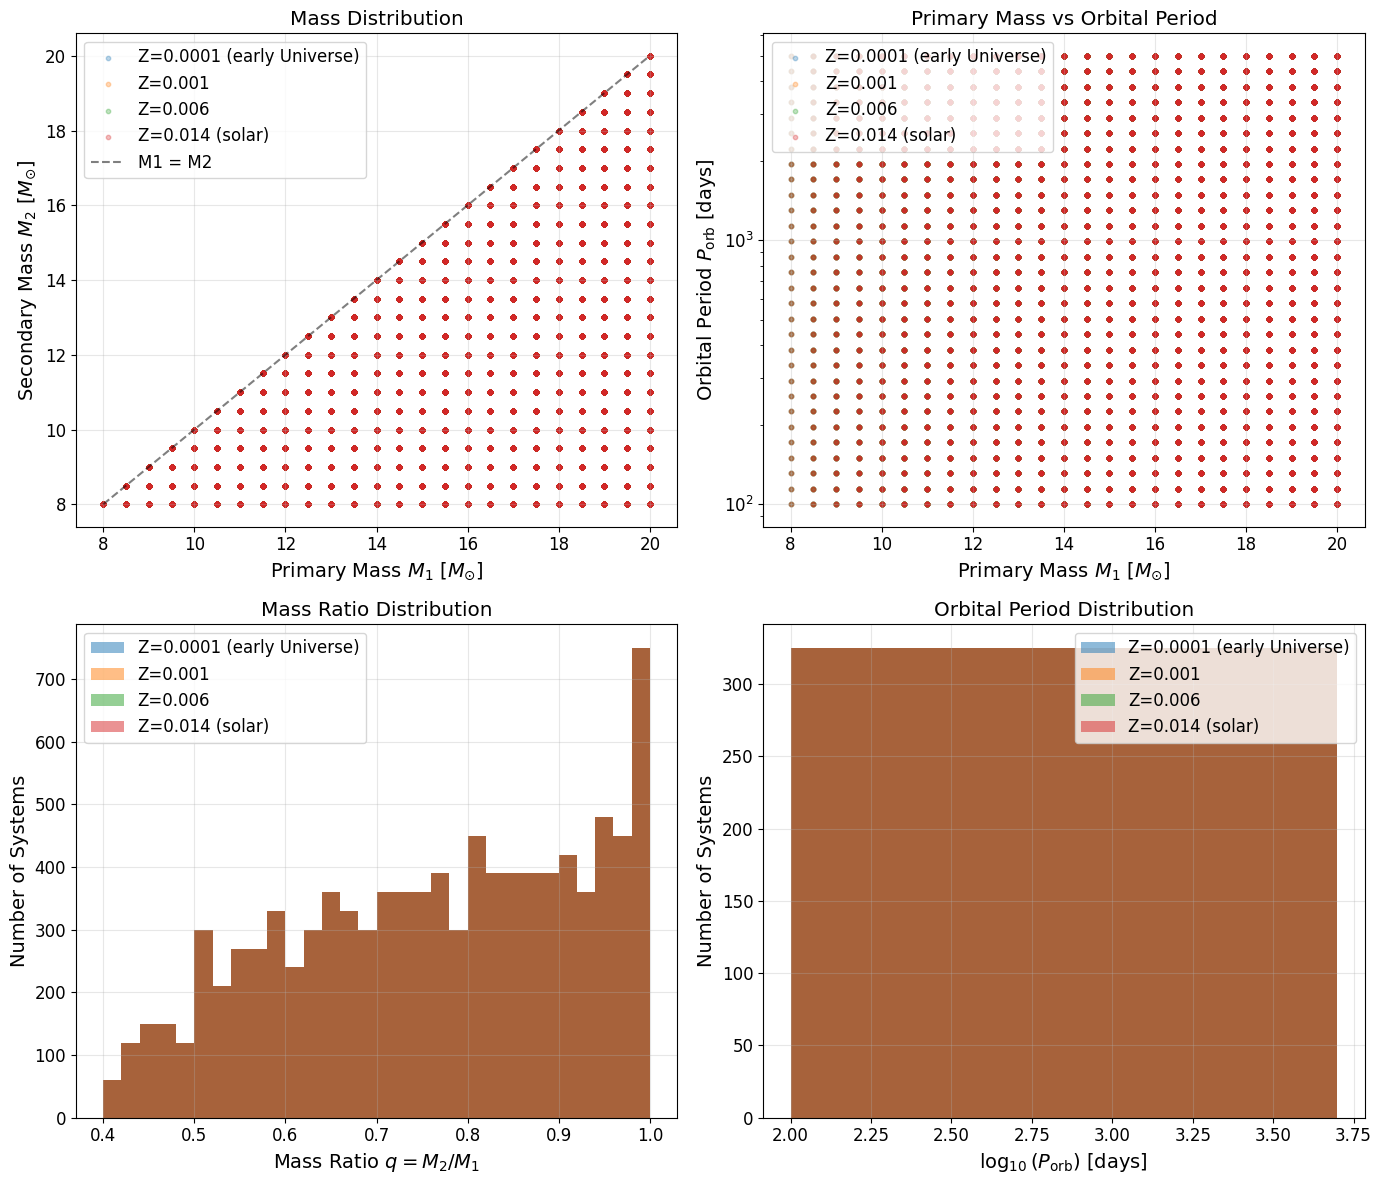

Parameter space visualization saved as 'initial_population_grid.png'


In [5]:
# Visualize the parameter space
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: M1 vs M2
ax = axes[0, 0]
for Z, label in zip(initial_params['metallicities'], initial_params['Z_labels']):
    subset = binary_grid[binary_grid['Z'] == Z]
    ax.scatter(subset['M1'], subset['M2'], alpha=0.3, s=10, label=label)
ax.plot([8, 20], [8, 20], 'k--', alpha=0.5, label='M1 = M2')
ax.set_xlabel('Primary Mass $M_1$ [$M_{\odot}$]')
ax.set_ylabel('Secondary Mass $M_2$ [$M_{\odot}$]')
ax.set_title('Mass Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: M1 vs P_orb
ax = axes[0, 1]
for Z, label in zip(initial_params['metallicities'], initial_params['Z_labels']):
    subset = binary_grid[binary_grid['Z'] == Z]
    ax.scatter(subset['M1'], subset['P_orb'], alpha=0.3, s=10, label=label)
ax.set_xlabel('Primary Mass $M_1$ [$M_{\odot}$]')
ax.set_ylabel('Orbital Period $P_{\\text{orb}}$ [days]')
ax.set_yscale('log')
ax.set_title('Primary Mass vs Orbital Period')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Mass ratio distribution
ax = axes[1, 0]
for Z, label in zip(initial_params['metallicities'], initial_params['Z_labels']):
    subset = binary_grid[binary_grid['Z'] == Z]
    ax.hist(subset['q'], bins=30, alpha=0.5, label=label)
ax.set_xlabel('Mass Ratio $q = M_2/M_1$')
ax.set_ylabel('Number of Systems')
ax.set_title('Mass Ratio Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Period distribution
ax = axes[1, 1]
for Z, label in zip(initial_params['metallicities'], initial_params['Z_labels']):
    subset = binary_grid[binary_grid['Z'] == Z]
    ax.hist(np.log10(subset['P_orb']), bins=30, alpha=0.5, label=label)
ax.set_xlabel('$\\log_{10}(P_{\\text{orb}})$ [days]')
ax.set_ylabel('Number of Systems')
ax.set_title('Orbital Period Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('initial_population_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("Parameter space visualization saved as 'initial_population_grid.png'")

## 4. Configure POSYDON Simulation

Set up the simulation properties and parameters for running the binary evolution.

In [6]:
# Configure simulation properties
# NOTE: You may need to adjust these paths based on your POSYDON data location

def setup_simulation_properties():
    """
    Configure POSYDON simulation properties.
    """
    # This is a template - adjust paths to your POSYDON_data location
    sim_prop = SimulationProperties(
        flow_chart=flow_chart,  # Use default POSYDON flow chart
        
        # Common Envelope parameters
        common_envelope_alpha_thermal=1.0,  # CE efficiency (can vary this)
        common_envelope_option_for_lambda='lambda_from_grid_final_values',  # Use grid lambdas
        common_envelope_lambda_default=0.5,  # Fallback value if grid fails
        
        # Metallicity will be set per binary
        metallicity=0.014,  # Default, will be overridden
        
        # Other evolution parameters
        max_simulation_time=13.8e9,  # Age of universe in years
    )
    
    return sim_prop

# Create simulation properties object
sim_properties = setup_simulation_properties()
print("Simulation properties configured")
print(f"  CE alpha_thermal: {sim_properties.common_envelope_alpha_thermal}")
print(f"  CE lambda option: {sim_properties.common_envelope_option_for_lambda}")
print(f"  Max simulation time: {sim_properties.max_simulation_time/1e9:.1f} Gyr")

Simulation properties configured
  CE alpha_thermal: 1.0
  CE lambda option: lambda_from_grid_final_values
  Max simulation time: 13.8 Gyr


## 5. Run Sample Evolution (Single Binary)

Before running the full grid, let's evolve a single binary to understand the output.

In [7]:
def evolve_single_binary(M1, M2, P_orb, Z, sim_prop):
    """
    Evolve a single binary system.
    
    Parameters:
    -----------
    M1 : float
        Primary mass in solar masses
    M2 : float
        Secondary mass in solar masses
    P_orb : float
        Orbital period in days
    Z : float
        Metallicity
    sim_prop : SimulationProperties
        POSYDON simulation properties
    
    Returns:
    --------
    binary : BinaryStar
        Evolved binary object
    """
    # Update metallicity
    sim_prop.metallicity = Z
    
    # Create binary
    binary = BinaryStar.from_run(
        m1=M1,
        m2=M2,
        period_days=P_orb,
        eccentricity=0.0,  # Assume circular orbits
        **sim_prop.__dict__
    )
    
    return binary

# Example: Evolve a typical DNS progenitor
print("Evolving sample binary...")
print("M1 = 12 M☉, M2 = 10 M☉, P = 500 days, Z = 0.014 (solar)")
print("\nNOTE: This requires POSYDON data grids to be downloaded.")
print("If grids are not ready, this cell will fail - you can skip for now.\n")

# Uncomment when grids are downloaded:
# sample_binary = evolve_single_binary(
#     M1=12.0,
#     M2=10.0,
#     P_orb=500.0,
#     Z=0.014,
#     sim_prop=sim_properties
# )
# print(f"Evolution complete! Final state: {sample_binary.state}")

Evolving sample binary...
M1 = 12 M☉, M2 = 10 M☉, P = 500 days, Z = 0.014 (solar)

NOTE: This requires POSYDON data grids to be downloaded.
If grids are not ready, this cell will fail - you can skip for now.



## 6. Extract Common Envelope Events

After evolution, we need to extract and analyze CE events.

In [8]:
def extract_CE_data(binary):
    """
    Extract Common Envelope event data from evolved binary.
    
    Returns:
    --------
    dict with CE properties
    """
    ce_data = {
        # Initial conditions
        'M1_initial': None,
        'M2_initial': None,
        'P_initial': None,
        'Z': None,
        
        # CE event properties
        'CE_occurred': False,
        'lambda_CE': None,  # Binding energy parameter
        'donor_state': None,  # RSG or YSG?
        'donor_mass_at_CE': None,
        'envelope_mass': None,
        
        # Outcome
        'survived_CE': False,
        'M1_final': None,
        'M2_final': None,
        'P_final': None,
        'final_state': None,
    }
    
    # Extract data from binary history
    # This is a template - actual implementation depends on POSYDON data structure
    
    # Check for CE in history
    # if 'step_CE' in binary.history:
    #     ce_data['CE_occurred'] = True
    #     # Extract lambda, donor state, etc.
    
    return ce_data

print("CE data extraction function defined")
print("\nKey variables to track:")
print("  - lambda_CE: Binding energy parameter of the envelope")
print("  - donor_state: Stellar type at CE (RSG/YSG)")
print("  - survived_CE: Did binary survive or merge?")

CE data extraction function defined

Key variables to track:
  - lambda_CE: Binding energy parameter of the envelope
  - donor_state: Stellar type at CE (RSG/YSG)
  - survived_CE: Did binary survive or merge?


## 7. Run Population Synthesis (Full Grid)

**WARNING**: This will take significant computational time. Start with a smaller subset for testing.

In [9]:
def run_population_grid(binary_grid, sim_prop, output_file='CE_population_results.h5'):
    """
    Run POSYDON evolution for entire binary grid.
    
    Parameters:
    -----------
    binary_grid : DataFrame
        Grid of initial conditions
    sim_prop : SimulationProperties
        POSYDON simulation properties
    output_file : str
        HDF5 file to save results
    """
    results = []
    
    total = len(binary_grid)
    print(f"Evolving {total} binary systems...")
    
    for idx, row in binary_grid.iterrows():
        if idx % 100 == 0:
            print(f"Progress: {idx}/{total} ({100*idx/total:.1f}%)")
        
        try:
            # Evolve binary
            binary = evolve_single_binary(
                M1=row['M1'],
                M2=row['M2'],
                P_orb=row['P_orb'],
                Z=row['Z'],
                sim_prop=sim_prop
            )
            
            # Extract CE data
            ce_data = extract_CE_data(binary)
            results.append(ce_data)
            
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            results.append(None)
    
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_hdf(output_file, key='results', mode='w')
    
    print(f"\nEvolution complete! Results saved to {output_file}")
    return results_df

# For testing, run a small subset first
print("IMPORTANT: Start with a small subset for testing!")
print("\nTo run full grid, uncomment below (requires data grids):")
print("# test_subset = binary_grid.sample(n=10)  # Test with 10 binaries")
print("# results = run_population_grid(test_subset, sim_properties, 'CE_test_results.h5')")

IMPORTANT: Start with a small subset for testing!

To run full grid, uncomment below (requires data grids):
# test_subset = binary_grid.sample(n=10)  # Test with 10 binaries
# results = run_population_grid(test_subset, sim_properties, 'CE_test_results.h5')


## 8. Analysis: Compare Grid-Based vs Fixed Lambda

This is the core of the research - comparing POSYDON's variable $\lambda$ to fixed models.

In [10]:
def compare_lambda_models(results_df, fixed_lambda_values=[0.1, 0.5]):
    """
    Compare CE outcomes with grid-based lambda vs fixed lambda.
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from POSYDON evolution
    fixed_lambda_values : list
        Fixed lambda values to compare against
    """
    # Filter for systems that underwent CE
    ce_systems = results_df[results_df['CE_occurred'] == True]
    
    print(f"Total systems that underwent CE: {len(ce_systems)}")
    print(f"Survival rate (POSYDON grid): {ce_systems['survived_CE'].mean():.2%}")
    
    # Analyze lambda distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Lambda distribution
    ax = axes[0, 0]
    ax.hist(ce_systems['lambda_CE'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    for fixed_lambda in fixed_lambda_values:
        ax.axvline(fixed_lambda, color='red', linestyle='--', 
                   label=f'Fixed $\\lambda = {fixed_lambda}$', linewidth=2)
    ax.set_xlabel('$\\lambda_{\\text{env}}$')
    ax.set_ylabel('Number of Systems')
    ax.set_title('Binding Energy Parameter Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Lambda vs Metallicity
    ax = axes[0, 1]
    for Z in ce_systems['Z'].unique():
        subset = ce_systems[ce_systems['Z'] == Z]
        ax.scatter(subset['Z'], subset['lambda_CE'], alpha=0.5, label=f'Z={Z}')
    ax.set_xlabel('Metallicity Z')
    ax.set_ylabel('$\\lambda_{\\text{env}}$')
    ax.set_xscale('log')
    ax.set_title('Lambda vs Metallicity')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Survival fraction by donor state
    ax = axes[1, 0]
    survival_by_state = ce_systems.groupby('donor_state')['survived_CE'].mean()
    survival_by_state.plot(kind='bar', ax=ax, color=['coral', 'skyblue'])
    ax.set_ylabel('Survival Fraction')
    ax.set_xlabel('Donor State at CE')
    ax.set_title('CE Survival by Donor Type')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Lambda vs Initial Mass
    ax = axes[1, 1]
    scatter = ax.scatter(ce_systems['M1_initial'], ce_systems['lambda_CE'], 
                        c=ce_systems['survived_CE'], cmap='RdYlGn', 
                        alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Primary Mass $M_1$ [$M_{\\odot}$]')
    ax.set_ylabel('$\\lambda_{\\text{env}}$')
    ax.set_title('Lambda vs Primary Mass (color = survived CE)')
    plt.colorbar(scatter, ax=ax, label='Survived CE')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lambda_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return ce_systems

print("Analysis function defined.")
print("\nTo run analysis on results:")
print("# ce_systems = compare_lambda_models(results_df)")

Analysis function defined.

To run analysis on results:
# ce_systems = compare_lambda_models(results_df)


## 9. Metallicity Dependence Analysis

In [11]:
def analyze_metallicity_effects(ce_systems):
    """
    Investigate the "Metallicity Problem" - does low Z create a death trap?
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Survival rate vs Metallicity
    ax = axes[0]
    survival_by_Z = ce_systems.groupby('Z')['survived_CE'].agg(['mean', 'count'])
    survival_by_Z['mean'].plot(ax=ax, marker='o', linewidth=2, markersize=10)
    ax.set_xlabel('Metallicity Z')
    ax.set_ylabel('CE Survival Fraction')
    ax.set_xscale('log')
    ax.set_title('Does Low Z Create a "Death Trap" for Binaries?')
    ax.grid(True, alpha=0.3)
    
    # Add text with counts
    for Z, row in survival_by_Z.iterrows():
        ax.annotate(f'n={int(row["count"])}', 
                   xy=(Z, row['mean']), 
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=9, alpha=0.7)
    
    # Plot 2: Average lambda vs Metallicity
    ax = axes[1]
    lambda_by_Z = ce_systems.groupby('Z')['lambda_CE'].agg(['mean', 'std'])
    lambda_by_Z['mean'].plot(ax=ax, marker='s', linewidth=2, markersize=10, 
                            yerr=lambda_by_Z['std'], capsize=5)
    ax.set_xlabel('Metallicity Z')
    ax.set_ylabel('Mean $\\lambda_{\\text{env}}$')
    ax.set_xscale('log')
    ax.set_title('Binding Energy Parameter vs Metallicity')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('metallicity_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n=== Metallicity Effects ===")
    for Z in sorted(ce_systems['Z'].unique()):
        subset = ce_systems[ce_systems['Z'] == Z]
        print(f"\nZ = {Z}:")
        print(f"  Number of CE events: {len(subset)}")
        print(f"  Survival rate: {subset['survived_CE'].mean():.2%}")
        print(f"  Mean lambda: {subset['lambda_CE'].mean():.3f} ± {subset['lambda_CE'].std():.3f}")
        print(f"  Lambda range: [{subset['lambda_CE'].min():.3f}, {subset['lambda_CE'].max():.3f}]")

print("Metallicity analysis function defined")

Metallicity analysis function defined


## 10. Energy Sources Analysis

Investigate if recombination energy matters for CE outcomes.

In [12]:
def analyze_energy_budget(ce_systems):
    """
    Analyze the role of recombination energy in CE outcomes.
    
    NOTE: This requires extracting E_rec from POSYDON data
    """
    # This is a template - implementation depends on available data
    
    print("Energy Sources Analysis:")
    print("\nKey questions to address:")
    print("1. What fraction of binding energy comes from recombination?")
    print("2. Does E_rec correlate with CE survival?")
    print("3. Is E_rec more important at certain masses or metallicities?")
    
    # If recombination energy data is available:
    # fig, ax = plt.subplots(figsize=(10, 6))
    # survived = ce_systems[ce_systems['survived_CE'] == True]
    # merged = ce_systems[ce_systems['survived_CE'] == False]
    # ax.scatter(survived['E_bind'], survived['E_rec'], label='Survived', alpha=0.6)
    # ax.scatter(merged['E_bind'], merged['E_rec'], label='Merged', alpha=0.6)
    # ...

print("Energy analysis function defined")

Energy analysis function defined


## 11. Save and Export Results

In [13]:
def export_results(ce_systems, output_dir='results'):
    """
    Export analysis results in various formats.
    """
    # Create output directory
    Path(output_dir).mkdir(exist_ok=True)
    
    # Save full results table
    ce_systems.to_csv(f'{output_dir}/CE_events_full.csv', index=False)
    print(f"Saved full results to {output_dir}/CE_events_full.csv")
    
    # Save summary statistics
    summary = ce_systems.groupby('Z').agg({
        'survived_CE': ['count', 'sum', 'mean'],
        'lambda_CE': ['mean', 'std', 'min', 'max'],
        'M1_initial': ['mean'],
        'P_initial': ['mean']
    })
    summary.to_csv(f'{output_dir}/CE_summary_by_metallicity.csv')
    print(f"Saved summary to {output_dir}/CE_summary_by_metallicity.csv")
    
    # Create README for results
    with open(f'{output_dir}/README.txt', 'w') as f:
        f.write("Common Envelope Evolution Analysis Results\n")
        f.write("="*50 + "\n\n")
        f.write(f"Total CE events analyzed: {len(ce_systems)}\n")
        f.write(f"Date: {pd.Timestamp.now()}\n")
        f.write(f"POSYDON version: {posydon.__version__}\n")
    
    print(f"\nAll results exported to '{output_dir}/' directory")

print("Export function defined")

Export function defined


## 12. Next Steps

Once POSYDON data grids are downloaded:

1. **Test with small sample**: Run evolution on 10-20 binaries to verify setup
2. **Run full grid**: Execute population synthesis on full parameter space
3. **Analyze results**: Use the analysis functions to investigate the three main problems
4. **Compare to literature**: Compare survival rates and lambda distributions to previous studies
5. **Write paper**: Document findings addressing each research question

### Key Outputs Expected:

1. **Survival rates** as function of (M1, M2, P, Z)
2. **Lambda distributions** - compare to fixed lambda = 0.1, 0.5
3. **Metallicity effects** - does low Z suppress DNS formation?
4. **Energy budget** - role of recombination energy
5. **Donor state dependence** - RSG vs YSG differences

In [14]:
# Summary of research workflow
print("="*60)
print("CE RESEARCH PROJECT WORKFLOW")
print("="*60)
print("\n1. ✓ Define parameter space (DONE)")
print("2. ✓ Create binary grid (DONE)")
print("3. ✓ Setup POSYDON simulation (DONE)")
print("4. ⏳ Wait for data grids to download (IN PROGRESS)")
print("5. ⏸  Test single binary evolution (PENDING)")
print("6. ⏸  Run population synthesis (PENDING)")
print("7. ⏸  Extract and analyze CE events (PENDING)")
print("8. ⏸  Compare to fixed-lambda models (PENDING)")
print("9. ⏸  Investigate metallicity effects (PENDING)")
print("10. ⏸  Publish results (PENDING)")
print("\n" + "="*60)
print("\nNext: Once grids are downloaded, start with Section 5!")
print("="*60)

CE RESEARCH PROJECT WORKFLOW

1. ✓ Define parameter space (DONE)
2. ✓ Create binary grid (DONE)
3. ✓ Setup POSYDON simulation (DONE)
4. ⏳ Wait for data grids to download (IN PROGRESS)
5. ⏸  Test single binary evolution (PENDING)
6. ⏸  Run population synthesis (PENDING)
7. ⏸  Extract and analyze CE events (PENDING)
8. ⏸  Compare to fixed-lambda models (PENDING)
9. ⏸  Investigate metallicity effects (PENDING)
10. ⏸  Publish results (PENDING)


Next: Once grids are downloaded, start with Section 5!
